# Fama-French模型源代码学习笔记（Python）

- reference: https://github.com/nkuguanrui/FamaFrenchThreeFacorModel
- todo：多因子简化板复现，因子预处理、检验、分析、优化、风险预测等

In [1333]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import seaborn
import statsmodels

# 使绘图在 Jupyter Notebook 中直接显示
%matplotlib inline

# 设置全局绘图尺寸（16x9 英寸）
plt.rcParams['figure.figsize'] = (16.0, 9.0)


# 数据
借用原项目收集好的数据集

- price.csv
  > PERMNO: 股票唯一永久 ID 整数（CRSP 内部标识）<br>
  > date: 交易日期 YYYY-MM-DD <br>
  > PRCT收盘价美元，负值表示 Bid 价 <br>
  > SHROUT流通股数千股（×1000 = 实际股数） <br>
  > EXCHCD:交易所代码 1=NYSE, 2=AMEX, 3=NASDAQ <br>

- value.csv
  > LPERMNO:Compustat 公司对应的 CRSP 股票 PERMNO, 连接财务数据与市场数据 <br>
  > datadate: 财报截止日期, 时间对齐，避免未来函数 <br>
  > bkvlps: 每股账面价值（美元), 计算 B/M，构建价值因子（HML）<br>

- rf.csv
  > date: 月份
  > rf： 每月无风险收益率（CRSP计算）

In [1154]:
price = pd.read_csv('price.csv',usecols=['PERMNO','date','PRC','SHROUT','EXCHCD'])
value = pd.read_csv('book.csv',usecols=['LPERMNO','datadate','bkvlps'])
rf = pd.read_csv('rf.csv',usecols=['qdate','ave_1'])

In [1155]:
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1660455 entries, 0 to 1660454
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   PERMNO  1660455 non-null  int64  
 1   date    1660455 non-null  int64  
 2   EXCHCD  1646961 non-null  float64
 3   PRC     1593710 non-null  float64
 4   SHROUT  1645000 non-null  float64
dtypes: float64(3), int64(2)
memory usage: 63.3 MB


In [1156]:
price.head()

,PERMNO,date,EXCHCD,PRC,SHROUT
0,10000,19851231,NaN,NaN,NaN
1,10000,19860131,3.0,-4.3750,3680.0
2,10000,19860228,3.0,-3.2500,3680.0
3,10000,19860331,3.0,-4.4375,3680.0
4,10000,19860430,3.0,-4.0000,3793.0


In [1157]:
value.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116248 entries, 0 to 116247
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   LPERMNO   116248 non-null  int64  
 1   datadate  116248 non-null  int64  
 2   bkvlps    108801 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.7 MB


In [1158]:
value.head()

,LPERMNO,datadate,bkvlps
0,25881,19701231,4.3107
1,25881,19711231,2.7987
2,25881,19721231,2.4194
3,25881,19731231,3.0165
4,25881,19741231,4.5781


In [1159]:
rf.info

<bound method DataFrame.info of         qdate  ave_1
0    19630131  2.929
1    19630228  2.843
2    19630329  2.853
3    19630430  2.858
4    19630531  2.960
..        ...    ...
343  19910830  5.306
344  19910930  4.989
345  19911031  4.786
346  19911129  4.063
347  19911231  3.717

[348 rows x 2 columns]>

In [1160]:
rf.head()

,qdate,ave_1
0,19630131,2.929
1,19630228,2.843
2,19630329,2.853
3,19630430,2.858
4,19630531,2.960


# Data Wrangling


### 处理rf表格，形成月度数据

In [1161]:
rf.head()

,qdate,ave_1
0,19630131,2.929
1,19630228,2.843
2,19630329,2.853
3,19630430,2.858
4,19630531,2.960


In [1162]:
rf = rf.rename(columns={rf.columns[0]: 'date', rf.columns[1]: 'rf'}) # 重命名国债收益率表格列名

In [1163]:
rf.head()# 检查列名

,date,rf
0,19630131,2.929
1,19630228,2.843
2,19630329,2.853
3,19630430,2.858
4,19630531,2.960


In [1164]:
rf["date"].dtype # 检查日期列数据类型 'int64'

dtype('int64')

In [1165]:
rf['date'] = rf['date'].apply(str)
rf['date'] = pd.to_datetime(rf['date'])# int64 -> str -> 时间序列

In [1166]:
rf["date"].dtype # 检查日期列数据类型变为时间序列 '<M8[ns]'

dtype('<M8[ns]')

In [1167]:
rf['year_month'] = rf['date'].dt.to_period('M') # 日期数据按月进行归一化（取整）

In [1168]:
rf.head() # 增加“year_month”列

,date,rf,year_month
0,1963-01-31,2.929,1963-01
1,1963-02-28,2.843,1963-02
2,1963-03-29,2.853,1963-03
3,1963-04-30,2.858,1963-04
4,1963-05-31,2.960,1963-05


In [1169]:
rf.drop(columns=['date'],inplace=True) #删除原date列，研究周期为月

In [1170]:
rf.head() 

,rf,year_month
0,2.929,1963-01
1,2.843,1963-02
2,2.853,1963-03
3,2.858,1963-04
4,2.960,1963-05


### 处理price数据

In [1171]:
price = pd.read_csv('price.csv',usecols=['PERMNO','date','PRC','SHROUT','EXCHCD'])

In [1172]:
price.head()

,PERMNO,date,EXCHCD,PRC,SHROUT
0,10000,19851231,NaN,NaN,NaN
1,10000,19860131,3.0,-4.3750,3680.0
2,10000,19860228,3.0,-3.2500,3680.0
3,10000,19860331,3.0,-4.4375,3680.0
4,10000,19860430,3.0,-4.0000,3793.0


In [1173]:
price = price.rename(columns={price.columns[0]: 'stock_code',
                                      price.columns[1]: 'date',
                                      price.columns[2]: 'exchange_code',
                                      price.columns[3]: 'price',
                                      price.columns[4]: 'shares'}) # 重命股价表格格列名

In [1174]:
price.head()

,stock_code,date,exchange_code,price,shares
0,10000,19851231,NaN,NaN,NaN
1,10000,19860131,3.0,-4.3750,3680.0
2,10000,19860228,3.0,-3.2500,3680.0
3,10000,19860331,3.0,-4.4375,3680.0
4,10000,19860430,3.0,-4.0000,3793.0


In [1175]:
price['date'] = price['date'].apply(str)
price['date'] = pd.to_datetime(price['date'])
price['year'] = price['date'].dt.year
price['year_month'] = price['date'].dt.to_period('M')
price['price'] = abs(price['price'])

In [1176]:
price.head()

,stock_code,date,exchange_code,price,shares,year,year_month
0,10000,1985-12-31,NaN,NaN,NaN,1985,1985-12
1,10000,1986-01-31,3.0,4.3750,3680.0,1986,1986-01
2,10000,1986-02-28,3.0,3.2500,3680.0,1986,1986-02
3,10000,1986-03-31,3.0,4.4375,3680.0,1986,1986-03
4,10000,1986-04-30,3.0,4.0000,3793.0,1986,1986-04


### 处理value数据

In [1177]:
value = pd.read_csv('book.csv',usecols=['LPERMNO','datadate','bkvlps'])


In [1178]:
# value.columns = ['stock_code','date','bookvaluepershare']
value = value.rename(columns={value.columns[0]:"stock_code",
                             value.columns[1]:"date",
                             value.columns[2]:"bookvaluepershare"}) # 更换列名

In [1179]:
value.head()

,stock_code,date,bookvaluepershare
0,25881,19701231,4.3107
1,25881,19711231,2.7987
2,25881,19721231,2.4194
3,25881,19731231,3.0165
4,25881,19741231,4.5781


In [1180]:
value["date"].dtype# 检查date的数据类型

dtype('int64')

In [1181]:
value['date'] = value['date'].apply(str)
value['date'] = pd.to_datetime(value['date']) # int64->str-><M8[ns] #改为时间序列

In [1182]:
value["date"].dtype 

dtype('<M8[ns]')

In [1183]:
value['year'] = value['date'].dt.year #股票价值表增加year列

In [1184]:
value.head()

,stock_code,date,bookvaluepershare,year
0,25881,1970-12-31,4.3107,1970
1,25881,1971-12-31,2.7987,1971
2,25881,1972-12-31,2.4194,1972
3,25881,1973-12-31,3.0165,1973
4,25881,1974-12-31,4.5781,1974


### 清洗三张表NaN、不合理值

In [1185]:
#去掉空值（dropna）,na代表空值
value.dropna(inplace=True)
price.dropna(inplace=True)
rf.dropna(inplace=True)

In [1186]:
price['exchange_code'].unique()

array([ 3.,  1.,  2., 33., 32., 31.])

In [1187]:
price = price.loc[price['exchange_code'].isin([1,2,3]),:]#获取（保留）三大交易所的股票
price.head()

,stock_code,date,exchange_code,price,shares,year,year_month
1,10000,1986-01-31,3.0,4.37500,3680.0,1986,1986-01
2,10000,1986-02-28,3.0,3.25000,3680.0,1986,1986-02
3,10000,1986-03-31,3.0,4.43750,3680.0,1986,1986-03
4,10000,1986-04-30,3.0,4.00000,3793.0,1986,1986-04
5,10000,1986-05-30,3.0,3.10938,3793.0,1986,1986-05


In [1188]:
price['exchange_code'].unique()

array([3., 1., 2.])

In [1189]:
value.head()

,stock_code,date,bookvaluepershare,year
0,25881,1970-12-31,4.3107,1970
1,25881,1971-12-31,2.7987,1971
2,25881,1972-12-31,2.4194,1972
3,25881,1973-12-31,3.0165,1973
4,25881,1974-12-31,4.5781,1974


In [1190]:
rf.head()

,rf,year_month
0,2.929,1963-01
1,2.843,1963-02
2,2.853,1963-03
3,2.858,1963-04
4,2.960,1963-05


In [1191]:
for df_name, df in [('rf', rf), ('price', price), ('value', value)]: #检查是否还有缺失值
    print(f"==== 检查 {df_name} 缺失值 ====")
    print(df.isna().sum())
    print("\n")

==== 检查 rf 缺失值 ====
rf            0
year_month    0
dtype: int64


==== 检查 price 缺失值 ====
stock_code       0
date             0
exchange_code    0
price            0
shares           0
year             0
year_month       0
dtype: int64


==== 检查 value 缺失值 ====
stock_code           0
date                 0
bookvaluepershare    0
year                 0
dtype: int64




# 数值计算
在分组前, 计算所需数值。研究周期为年<br>
BV(账面价值)=bookvaluepershare(每股账面价值)×shares(股本数量)<br>
MktCap(市值)=price×shares<br>
BM=BV/MktCap


### shares(price)保留年度数据

In [1192]:
shares = copy.deepcopy(price.loc[:,['stock_code','exchange_code',
                                    'price','shares','year','year_month']])

In [1193]:
shares.head()

,stock_code,exchange_code,price,shares,year,year_month
1,10000,3.0,4.37500,3680.0,1986,1986-01
2,10000,3.0,3.25000,3680.0,1986,1986-02
3,10000,3.0,4.43750,3680.0,1986,1986-03
4,10000,3.0,4.00000,3793.0,1986,1986-04
5,10000,3.0,3.10938,3793.0,1986,1986-05


In [1194]:
shares = shares.sort_values(['stock_code','year_month'])

In [1195]:
shares.head(20)

,stock_code,exchange_code,price,shares,year,year_month
1,10000,3.0,4.37500,3680.0,1986,1986-01
2,10000,3.0,3.25000,3680.0,1986,1986-02
3,10000,3.0,4.43750,3680.0,1986,1986-03
4,10000,3.0,4.00000,3793.0,1986,1986-04
5,10000,3.0,3.10938,3793.0,1986,1986-05
6,10000,3.0,3.09375,3793.0,1986,1986-06
7,10000,3.0,2.84375,3793.0,1986,1986-07
8,10000,3.0,1.09375,3793.0,1986,1986-08
9,10000,3.0,1.03125,3793.0,1986,1986-09
10,10000,3.0,0.78125,3843.0,1986,1986-10


In [1196]:
shares = shares.groupby(['stock_code','year']).last() # 只保留每年最后一天的股价，论文研究周期为年，可优化为月
shares.head()

exchange_code    price  shares year_month
stock_code year                                           
10000      1986            3.0  0.51563  3843.0    1986-12
           1987            3.0  0.21875  3893.0    1987-05
10001      1986            3.0  7.00000   991.0    1986-12
           1987            3.0  5.87500   992.0    1987-12
           1988            3.0  6.37500   998.0    1988-12

In [1197]:
shares.reset_index(inplace=True)
shares

,stock_code,year,exchange_code,price,shares,year_month
0,10000,1986,3.0,0.51563,3843.0,1986-12
1,10000,1987,3.0,0.21875,3893.0,1987-05
2,10001,1986,3.0,7.00000,991.0,1986-12
3,10001,1987,3.0,5.87500,992.0,1987-12
4,10001,1988,3.0,6.37500,998.0,1988-12
...,...,...,...,...,...,...
145750,93316,1989,3.0,3.00000,2696.0,1989-12
145751,93316,1990,3.0,1.68750,2696.0,1990-12
145752,93316,1991,3.0,2.18750,2696.0,1991-12
145753,93324,1984,3.0,0.48438,14715.0,1984-12


In [1198]:
shares.dropna(inplace=True)
shares.head()

,stock_code,year,exchange_code,price,shares,year_month
0,10000,1986,3.0,0.51563,3843.0,1986-12
1,10000,1987,3.0,0.21875,3893.0,1987-05
2,10001,1986,3.0,7.00000,991.0,1986-12
3,10001,1987,3.0,5.87500,992.0,1987-12
4,10001,1988,3.0,6.37500,998.0,1988-12


### values保留年度数据

In [1199]:
value = value.sort_values(['stock_code','date'])
value = value.groupby(['stock_code','year']).last()
value.reset_index(inplace=True) # booktovaluepershare 
# Book Value 的数据频率本身是年度

In [1200]:
value.head()

,stock_code,year,date,bookvaluepershare
0,10000,1986,1986-10-31,0.1088
1,10001,1986,1986-06-30,5.5147
2,10001,1987,1987-06-30,5.4178
3,10001,1988,1988-06-30,5.5565
4,10001,1989,1989-06-30,6.3147


In [1201]:
shares.drop(columns=['year_month'],inplace=True)
value.drop(columns=['date'],inplace=True)

### 合并股票股价和市值数据

In [1202]:
bm_df = pd.merge(shares,value,on=['stock_code','year'])

### 计算bm（年度）

In [1203]:
bm_df['bv'] = bm_df['bookvaluepershare']*bm_df['shares']*1000 #数据库中的股数除了1000 BV(账面价值)=bookvaluepershare(每股账面价值)×shares(股本数量)

In [1204]:
bm_df['mktcap'] = bm_df['price']*bm_df['shares']*1000 # MktCap市值)=price×shares

In [1205]:
bm_df.drop(columns=['bookvaluepershare','price'],inplace=True)

In [1206]:
bm_df.drop(columns=['shares'],inplace=True)

In [1207]:
bm_df.head(20) 

,stock_code,year,exchange_code,bv,mktcap
0,10000,1986,3.0,418118.4,1.981566e+06
1,10001,1986,3.0,5465067.7,6.937000e+06
2,10001,1987,3.0,5374457.6,5.828000e+06
3,10001,1988,3.0,5545387.0,6.362250e+06
4,10001,1989,3.0,6453623.4,1.034775e+07
5,10001,1990,3.0,7339107.4,1.001300e+07
6,10001,1991,3.0,7996925.0,1.558750e+07
7,10005,1986,3.0,1899898.2,4.336875e+05
8,10005,1987,3.0,2494372.8,1.177917e+06
9,10005,1988,3.0,1282365.6,7.852500e+05


In [1208]:
bm_df['bm'] = bm_df['bv']/bm_df['mktcap'] # BM=BV/MktCap
bm_df.drop(columns=['bv'],inplace=True)

In [1209]:
bm_df.drop(columns=['mktcap'],inplace=True)


In [1210]:
bm_df

,stock_code,year,exchange_code,bm
0,10000,1986,3.0,0.211004
1,10001,1986,3.0,0.787814
2,10001,1987,3.0,0.922179
3,10001,1988,3.0,0.871608
4,10001,1989,3.0,0.623674
...,...,...,...,...
106044,93316,1988,3.0,1.980296
106045,93316,1989,3.0,2.259033
106046,93316,1990,3.0,4.071644
106047,93316,1991,3.0,3.102994


### 计算市值

In [1211]:
mktcap_df = copy.deepcopy(price.loc[:,['stock_code','exchange_code',
                                    'price','shares','year_month']])

In [1212]:
mktcap_df.dropna(inplace=True)
mktcap_df['mktcap'] = mktcap_df['price']*mktcap_df['shares']*1000 # MktCap(市值)=price×shares
mktcap_df.drop(columns=['price','shares'],inplace=True)

In [1213]:
mktcap_df.head()

,stock_code,exchange_code,year_month,mktcap
1,10000,3.0,1986-01,16100000.00
2,10000,3.0,1986-02,11960000.00
3,10000,3.0,1986-03,16330000.00
4,10000,3.0,1986-04,15172000.00
5,10000,3.0,1986-05,11793878.34


### 计算股票收益率

In [1214]:
ret_df = copy.deepcopy(price.loc[:,['stock_code','price','year_month']])

In [1215]:
ret_df.dropna(inplace=True)

In [1216]:
ret_df.head()

,stock_code,price,year_month
1,10000,4.37500,1986-01
2,10000,3.25000,1986-02
3,10000,4.43750,1986-03
4,10000,4.00000,1986-04
5,10000,3.10938,1986-05


In [1217]:
ret_df['ret'] = ret_df.groupby(['stock_code'])['price'].pct_change() #月收益率

In [1218]:
ret_df.dropna(inplace=True)
ret_df.drop(columns=['price'],inplace=True)
ret_df.head()

,stock_code,year_month,ret
2,10000,1986-02,-0.257143
3,10000,1986-03,0.365385
4,10000,1986-04,-0.098592
5,10000,1986-05,-0.222655
6,10000,1986-06,-0.005027


### 转化国债收益率单位

In [1219]:
rf['rf'] = rf['rf']/12   # 合并月度表格

In [1220]:
rf['rf'] = rf['rf']/100
rf.head()

,rf,year_month
0,0.002441,1963-01
1,0.002369,1963-02
2,0.002378,1963-03
3,0.002382,1963-04
4,0.002467,1963-05


### 计算因变量超额收益率（因变量）

In [1221]:
exret_df = pd.merge(ret_df,rf,on=['year_month'])

In [1222]:
exret_df.sort_values(['stock_code','year_month'],inplace=True)

In [1223]:
exret_df.reset_index(drop=True,inplace=True)
exret_df['ex_ret'] = exret_df['ret'] - exret_df['rf']
exret_df.head()

,stock_code,year_month,ret,rf,ex_ret
0,10000,1986-02,-0.257143,0.005789,-0.262932
1,10000,1986-03,0.365385,0.005227,0.360158
2,10000,1986-04,-0.098592,0.004915,-0.103507
3,10000,1986-05,-0.222655,0.005127,-0.227782
4,10000,1986-06,-0.005027,0.004904,-0.009931


### bm年份值向前shift一年合并超额收益表会计年度 t 的 BM → 标记为 t+1 才可用

In [1224]:
bm_df.head()

,stock_code,year,exchange_code,bm
0,10000,1986,3.0,0.211004
1,10001,1986,3.0,0.787814
2,10001,1987,3.0,0.922179
3,10001,1988,3.0,0.871608
4,10001,1989,3.0,0.623674


In [1225]:
exret_df['year'] = exret_df['year_month'].dt.year
exret_df['month'] = exret_df['year_month'].dt.month

In [1226]:
exret_df.head()

,stock_code,year_month,ret,rf,ex_ret,year,month
0,10000,1986-02,-0.257143,0.005789,-0.262932,1986,2
1,10000,1986-03,0.365385,0.005227,0.360158,1986,3
2,10000,1986-04,-0.098592,0.004915,-0.103507,1986,4
3,10000,1986-05,-0.222655,0.005127,-0.227782,1986,5
4,10000,1986-06,-0.005027,0.004904,-0.009931,1986,6


In [1227]:
exret_df['bm_date'] = exret_df['year'] - 1

In [1228]:
exret_df.head()

,stock_code,year_month,ret,rf,ex_ret,year,month,bm_date
0,10000,1986-02,-0.257143,0.005789,-0.262932,1986,2,1985
1,10000,1986-03,0.365385,0.005227,0.360158,1986,3,1985
2,10000,1986-04,-0.098592,0.004915,-0.103507,1986,4,1985
3,10000,1986-05,-0.222655,0.005127,-0.227782,1986,5,1985
4,10000,1986-06,-0.005027,0.004904,-0.009931,1986,6,1985


### 论文的 “July t – June t+1” 规则（BM Ratio）

In [1229]:
idx = exret_df['month'].isin([1,2,3,4,5,6])
exret_df.loc[idx,'bm_date'] = exret_df.loc[idx,'bm_date'] - 1

In [1230]:
exret_df.head(10)

,stock_code,year_month,ret,rf,ex_ret,year,month,bm_date
0,10000,1986-02,-0.257143,0.005789,-0.262932,1986,2,1984
1,10000,1986-03,0.365385,0.005227,0.360158,1986,3,1984
2,10000,1986-04,-0.098592,0.004915,-0.103507,1986,4,1984
3,10000,1986-05,-0.222655,0.005127,-0.227782,1986,5,1984
4,10000,1986-06,-0.005027,0.004904,-0.009931,1986,6,1984
5,10000,1986-07,-0.080808,0.004693,-0.085501,1986,7,1985
6,10000,1986-08,-0.615385,0.004268,-0.619653,1986,8,1985
7,10000,1986-09,-0.057143,0.004259,-0.061402,1986,9,1985
8,10000,1986-10,-0.242424,0.004268,-0.246693,1986,10,1985
9,10000,1986-11,0.060006,0.004133,0.055873,1986,11,1985


In [1231]:
bm_df.rename(columns={'year':'bm_date'},inplace=True)

In [1232]:
bm_df.head()

,stock_code,bm_date,exchange_code,bm
0,10000,1986,3.0,0.211004
1,10001,1986,3.0,0.787814
2,10001,1987,3.0,0.922179
3,10001,1988,3.0,0.871608
4,10001,1989,3.0,0.623674


### 合并股票和BM表

In [1233]:
sort_df = pd.merge(exret_df,bm_df,on=['stock_code','bm_date'])

In [1234]:
sort_df.tail()

,stock_code,year_month,ret,rf,ex_ret,year,month,bm_date,exchange_code,bm
1093616,93316,1991-08,0.027778,0.004422,0.023356,1991,8,1990,3.0,4.071644
1093617,93316,1991-09,-0.081081,0.004157,-0.085239,1991,9,1990,3.0,4.071644
1093618,93316,1991-10,0.088235,0.003988,0.084247,1991,10,1990,3.0,4.071644
1093619,93316,1991-11,0.054054,0.003386,0.050668,1991,11,1990,3.0,4.071644
1093620,93316,1991-12,-0.102564,0.003098,-0.105662,1991,12,1990,3.0,4.071644


###  论文的 “July t – June t+1” 规则（BM Ratio）

In [1235]:
sort_df['mkt_date'] = sort_df['year']
idx = sort_df['month'].isin([1,2,3,4,5,6])
sort_df.loc[idx,'mkt_date'] = sort_df.loc[idx,'mkt_date'] - 1

In [1236]:
sort_df.head()

,stock_code,year_month,ret,rf,ex_ret,year,month,bm_date,exchange_code,bm,mkt_date
0,10001,1987-07,0.021277,0.004667,0.016609,1987,7,1986,3.0,0.787814,1987
1,10001,1987-08,0.083333,0.004717,0.078616,1987,8,1986,3.0,0.787814,1987
2,10001,1987-09,-0.038462,0.005417,-0.043878,1987,9,1986,3.0,0.787814,1987
3,10001,1987-10,0.020000,0.003353,0.016648,1987,10,1986,3.0,0.787814,1987
4,10001,1987-11,-0.029412,0.002927,-0.032339,1987,11,1986,3.0,0.787814,1987


In [1237]:
sort_df.tail(12) # 检查mkt_date  # "July t – June t+1” 规则

,stock_code,year_month,ret,rf,ex_ret,year,month,bm_date,exchange_code,bm,mkt_date
1093609,93316,1991-01,0.222222,0.004897,0.217325,1991,1,1989,3.0,2.259033,1990
1093610,93316,1991-02,-0.060606,0.004762,-0.065368,1991,2,1989,3.0,2.259033,1990
1093611,93316,1991-03,0.161290,0.004906,0.156384,1991,3,1989,3.0,2.259033,1990
1093612,93316,1991-04,0.000000,0.004513,-0.004513,1991,4,1989,3.0,2.259033,1990
1093613,93316,1991-05,0.055556,0.004490,0.051066,1991,5,1989,3.0,2.259033,1990
1093614,93316,1991-06,0.000000,0.004319,-0.004319,1991,6,1989,3.0,2.259033,1990
1093615,93316,1991-07,-0.052632,0.004618,-0.057249,1991,7,1990,3.0,4.071644,1991
1093616,93316,1991-08,0.027778,0.004422,0.023356,1991,8,1990,3.0,4.071644,1991
1093617,93316,1991-09,-0.081081,0.004157,-0.085239,1991,9,1990,3.0,4.071644,1991
1093618,93316,1991-10,0.088235,0.003988,0.084247,1991,10,1990,3.0,4.071644,1991


### FF模型 6月时间点规则 “年”不是时间点。

In [1238]:
sort_df['mkt_date'] = pd.to_datetime(sort_df['mkt_date'].astype('str')
                                      ,format='%Y') +pd.DateOffset(months=5)

In [1239]:
sort_df.head()

,stock_code,year_month,ret,rf,ex_ret,year,month,bm_date,exchange_code,bm,mkt_date
0,10001,1987-07,0.021277,0.004667,0.016609,1987,7,1986,3.0,0.787814,1987-06-01
1,10001,1987-08,0.083333,0.004717,0.078616,1987,8,1986,3.0,0.787814,1987-06-01
2,10001,1987-09,-0.038462,0.005417,-0.043878,1987,9,1986,3.0,0.787814,1987-06-01
3,10001,1987-10,0.020000,0.003353,0.016648,1987,10,1986,3.0,0.787814,1987-06-01
4,10001,1987-11,-0.029412,0.002927,-0.032339,1987,11,1986,3.0,0.787814,1987-06-01


### 时间颗粒度变月

In [1240]:
sort_df['mkt_date'] = sort_df['mkt_date'].dt.to_period('M')

In [1241]:
mktcap_df.head()

,stock_code,exchange_code,year_month,mktcap
1,10000,3.0,1986-01,16100000.00
2,10000,3.0,1986-02,11960000.00
3,10000,3.0,1986-03,16330000.00
4,10000,3.0,1986-04,15172000.00
5,10000,3.0,1986-05,11793878.34


### exchange_code_x / y
exchange_code 的作用不是“算因子”，而是“定义什么是‘正常市场结构’”

In [1242]:
mktcap_df.rename(columns={'year_month':'mkt_date'},inplace=True)

In [1243]:
sort_df = pd.merge(sort_df,mktcap_df,on=['stock_code','mkt_date'])

In [1244]:
sort_df.head()

,stock_code,year_month,ret,rf,ex_ret,year,month,bm_date,exchange_code_x,bm,mkt_date,exchange_code_y,mktcap
0,10001,1987-07,0.021277,0.004667,0.016609,1987,7,1986,3.0,0.787814,1987-06,3.0,5822125.0
1,10001,1987-08,0.083333,0.004717,0.078616,1987,8,1986,3.0,0.787814,1987-06,3.0,5822125.0
2,10001,1987-09,-0.038462,0.005417,-0.043878,1987,9,1986,3.0,0.787814,1987-06,3.0,5822125.0
3,10001,1987-10,0.020000,0.003353,0.016648,1987,10,1986,3.0,0.787814,1987-06,3.0,5822125.0
4,10001,1987-11,-0.029412,0.002927,-0.032339,1987,11,1986,3.0,0.787814,1987-06,3.0,5822125.0


# 因子计算

In [1245]:
sort_df_ = copy.deepcopy(sort_df)

In [1246]:
sort_df.drop(columns=['year','month','exchange_code_x'],inplace=True)
sort_df.rename(columns={'exchange_code_y':'exchange_code'},inplace=True)

In [1247]:
sort_df_.head()

,stock_code,year_month,ret,rf,ex_ret,year,month,bm_date,exchange_code_x,bm,mkt_date,exchange_code_y,mktcap
0,10001,1987-07,0.021277,0.004667,0.016609,1987,7,1986,3.0,0.787814,1987-06,3.0,5822125.0
1,10001,1987-08,0.083333,0.004717,0.078616,1987,8,1986,3.0,0.787814,1987-06,3.0,5822125.0
2,10001,1987-09,-0.038462,0.005417,-0.043878,1987,9,1986,3.0,0.787814,1987-06,3.0,5822125.0
3,10001,1987-10,0.020000,0.003353,0.016648,1987,10,1986,3.0,0.787814,1987-06,3.0,5822125.0
4,10001,1987-11,-0.029412,0.002927,-0.032339,1987,11,1986,3.0,0.787814,1987-06,3.0,5822125.0


### 分组 

- New York Stock Exchange

- American Stock Exchange

- The Nasdaq Stock Market(SM)

In [1248]:
#对bm进行分组，准备HML分组
quantile_df = pd.DataFrame() 
NYSE = copy.deepcopy(sort_df[sort_df['exchange_code'] == 1])
NYSE = copy.deepcopy(NYSE[NYSE['bm']>=0])
# We do not use negative-BE firms, when calculating the breakpoints for BM
#or when forming the size-BM portfolios. 

In [1249]:
quantile_df['q1'] = NYSE.groupby(['year_month'])['bm'].quantile(0.3)
quantile_df['q2'] = NYSE.groupby(['year_month'])['bm'].quantile(0.7)

In [1250]:
sort_df = pd.merge(sort_df,quantile_df,on=['year_month']) # 把“BM 分组阈值（breakpoints）”贴回到每一只股票上

In [1251]:
sort_df.head()

,stock_code,year_month,ret,rf,ex_ret,bm_date,bm,mkt_date,exchange_code,mktcap,q1,q2
0,10001,1987-07,0.021277,0.004667,0.016609,1986,0.787814,1987-06,3.0,5822125.0,0.499040,0.823082
1,10001,1987-08,0.083333,0.004717,0.078616,1986,0.787814,1987-06,3.0,5822125.0,0.500350,0.823708
2,10001,1987-09,-0.038462,0.005417,-0.043878,1986,0.787814,1987-06,3.0,5822125.0,0.500265,0.823809
3,10001,1987-10,0.020000,0.003353,0.016648,1986,0.787814,1987-06,3.0,5822125.0,0.500634,0.823339
4,10001,1987-11,-0.029412,0.002927,-0.032339,1986,0.787814,1987-06,3.0,5822125.0,0.500011,0.823416


In [1252]:
quantile_size_df = pd.DataFrame()
quantile_size_df['Q'] = NYSE.groupby(['year_month'])['mktcap'].quantile(0.5)

In [1253]:
# NYSE[NYSE['year_month'].dt.year == 1963] ##？？？？？？？这步没理解

In [1254]:
sort_df = pd.merge(sort_df,quantile_size_df,on=['year_month']) 
# 把 Size（市值）分组的断点（Small / Big）贴回到每一只股票上 每只股票对应Small/Big

In [1255]:
sort_df.head()

,stock_code,year_month,ret,rf,ex_ret,bm_date,bm,mkt_date,exchange_code,mktcap,q1,q2,Q
0,10001,1987-07,0.021277,0.004667,0.016609,1986,0.787814,1987-06,3.0,5822125.0,0.499040,0.823082,490434312.5
1,10001,1987-08,0.083333,0.004717,0.078616,1986,0.787814,1987-06,3.0,5822125.0,0.500350,0.823708,487342312.5
2,10001,1987-09,-0.038462,0.005417,-0.043878,1986,0.787814,1987-06,3.0,5822125.0,0.500265,0.823809,490282375.0
3,10001,1987-10,0.020000,0.003353,0.016648,1986,0.787814,1987-06,3.0,5822125.0,0.500634,0.823339,490434312.5
4,10001,1987-11,-0.029412,0.002927,-0.032339,1986,0.787814,1987-06,3.0,5822125.0,0.500011,0.823416,489705687.5


In [1256]:
sort_df.rename(columns={'Q_x':'Q'},inplace=True)

In [1257]:
sort_df.head()

,stock_code,year_month,ret,rf,ex_ret,bm_date,bm,mkt_date,exchange_code,mktcap,q1,q2,Q
0,10001,1987-07,0.021277,0.004667,0.016609,1986,0.787814,1987-06,3.0,5822125.0,0.499040,0.823082,490434312.5
1,10001,1987-08,0.083333,0.004717,0.078616,1986,0.787814,1987-06,3.0,5822125.0,0.500350,0.823708,487342312.5
2,10001,1987-09,-0.038462,0.005417,-0.043878,1986,0.787814,1987-06,3.0,5822125.0,0.500265,0.823809,490282375.0
3,10001,1987-10,0.020000,0.003353,0.016648,1986,0.787814,1987-06,3.0,5822125.0,0.500634,0.823339,490434312.5
4,10001,1987-11,-0.029412,0.002927,-0.032339,1986,0.787814,1987-06,3.0,5822125.0,0.500011,0.823416,489705687.5


In [1258]:
sort_df.dropna(inplace=True)
sort_df.head()

,stock_code,year_month,ret,rf,ex_ret,bm_date,bm,mkt_date,exchange_code,mktcap,q1,q2,Q
0,10001,1987-07,0.021277,0.004667,0.016609,1986,0.787814,1987-06,3.0,5822125.0,0.499040,0.823082,490434312.5
1,10001,1987-08,0.083333,0.004717,0.078616,1986,0.787814,1987-06,3.0,5822125.0,0.500350,0.823708,487342312.5
2,10001,1987-09,-0.038462,0.005417,-0.043878,1986,0.787814,1987-06,3.0,5822125.0,0.500265,0.823809,490282375.0
3,10001,1987-10,0.020000,0.003353,0.016648,1986,0.787814,1987-06,3.0,5822125.0,0.500634,0.823339,490434312.5
4,10001,1987-11,-0.029412,0.002927,-0.032339,1986,0.787814,1987-06,3.0,5822125.0,0.500011,0.823416,489705687.5


In [1259]:
sort_df.drop(columns=['bm_date','mkt_date'],inplace=True)

In [1260]:
sort_df.columns

Index(['stock_code', 'year_month', 'ret', 'rf', 'ex_ret', 'bm',
       'exchange_code', 'mktcap', 'q1', 'q2', 'Q'],
      dtype='object')

### BM 分组 (账面价值分三组)
p1: Low BM<br>
p2: Medium BM<br>
p3: High BM<br>

In [1261]:
portfolios_by_bm = dict()
keep_cols= ['stock_code', 'year_month', 'ret', 'rf', 'ex_ret', 'bm','mktcap']
idx = sort_df['bm']<=sort_df['q1']
portfolios_by_bm['p1'] = sort_df.loc[idx,keep_cols]

In [1262]:
idx = ((sort_df['bm']>=sort_df['q1']) & (sort_df['bm']<=sort_df['q2']))
portfolios_by_bm['p2'] = sort_df.loc[idx,keep_cols]
idx = sort_df['bm'] >= sort_df['q2']
portfolios_by_bm['p3'] = sort_df.loc[idx,keep_cols]

In [1263]:
for key in portfolios_by_bm.keys():
    portfolios_by_bm[key] = portfolios_by_bm[key][portfolios_by_bm[key]['bm']>=0]

### 市值规模分2组
q1：BM 30% <br>
q2：BM 70%

In [1264]:
portfolios_by_size = dict()
keep_cols= ['stock_code', 'year_month', 'ret', 'rf', 'ex_ret', 'bm','mktcap']
idx = sort_df['mktcap']<=sort_df['Q']
portfolios_by_size['P1'] = sort_df.loc[idx,keep_cols]
idx = sort_df['mktcap']>=sort_df['Q']
portfolios_by_size['P2'] = sort_df.loc[idx,keep_cols]

In [1265]:
portfolios_by_size['P2'].head()

,stock_code,year_month,ret,rf,ex_ret,bm,mktcap
102,10006,1965-07,0.009709,0.003140,0.006569,0.590897,229278000.0
103,10006,1965-08,0.048077,0.003152,0.044924,0.590897,229278000.0
104,10006,1965-09,-0.506116,0.003322,-0.509438,0.590897,229278000.0
105,10006,1965-10,0.108359,0.003208,0.105152,0.590897,229278000.0
106,10006,1965-11,-0.019553,0.003165,-0.022718,0.590897,229278000.0


### 交叉分组筛选股票池，把分组标签对应数据

In [1266]:
portfolios = dict()
for bm in portfolios_by_bm.keys():
    for mkt in portfolios_by_size.keys():
        portfolios[f'{bm}_{mkt}'] = pd.merge(portfolios_by_bm[bm][['stock_code','year_month']],
                                            portfolios_by_size[mkt],
                                             on=['stock_code','year_month'])

In [1267]:
portfolios.keys()

dict_keys(['p1_P1', 'p1_P2', 'p2_P1', 'p2_P2', 'p3_P1', 'p3_P2'])

### 组合的市值加权月收益（6个分组的每个周期加权收益，6*n）

In [1268]:
portfolios_vwret = dict()
for pf in portfolios.keys():
    temp = pd.DataFrame(portfolios[pf].groupby('year_month')['mktcap'].sum())#计算某个年月的市值总和
    temp.columns = ['mktcap_sum']
    portfolios[pf] = pd.merge(portfolios[pf],temp,on=['year_month'])#将mktsum加入原来的DataFrame
    portfolios[pf]['weight'] = portfolios[pf][
        'mktcap']/portfolios[pf]['mktcap_sum']#添加一列求市值权重
    portfolios[pf]['weighted_ret'] = portfolios[pf]['weight']*portfolios[pf]['ret']
    portfolios_vwret[pf] = portfolios[pf].groupby(['year_month'])[
        ['weighted_ret']].sum()

In [1269]:
portfolios_vwret['p1_P1'].head()

,weighted_ret
year_month,
1964-07,0.047100
1964-08,-0.006055
1964-09,0.024405
1964-10,0.031740
1964-11,0.020627


In [1270]:
portfolios_vwret

{'p1_P1':             weighted_ret
 year_month              
 1964-07         0.047100
 1964-08        -0.006055
 1964-09         0.024405
 1964-10         0.031740
 1964-11         0.020627
 ...                  ...
 1991-08         0.027545
 1991-09         0.005383
 1991-10         0.015610
 1991-11        -0.030457
 1991-12         0.090287
 
 [330 rows x 1 columns],
 'p1_P2':             weighted_ret
 year_month              
 1964-07         0.027194
 1964-08        -0.015123
 1964-09         0.026426
 1964-10         0.000392
 1964-11        -0.019613
 ...                  ...
 1991-08         0.024443
 1991-09        -0.024004
 1991-10         0.012668
 1991-11        -0.033387
 1991-12         0.115436
 
 [330 rows x 1 columns],
 'p2_P1':             weighted_ret
 year_month              
 1964-07        -0.003801
 1964-08         0.000532
 1964-09         0.028011
 1964-10         0.014604
 1964-11         0.002863
 ...                  ...
 1991-08         0.033203
 1991-09 

In [1271]:
### pivot table

In [1272]:
portfolios_vwret_df = pd.DataFrame(np.hstack([pf for pf in portfolios_vwret.values()]))
portfolios_vwret_df.index = portfolios_vwret['p1_P1'].index
portfolios_vwret_df.columns = portfolios_vwret.keys()

In [1273]:
portfolios_vwret_df.head()

,p1_P1,p1_P2,p2_P1,p2_P2,p3_P1,p3_P2
year_month,,,,,,
1964-07,0.047100,0.027194,-0.003801,0.004489,0.016559,0.011829
1964-08,-0.006055,-0.015123,0.000532,-0.021728,-0.008961,-0.027789
1964-09,0.024405,0.026426,0.028011,0.014669,0.030932,0.039027
1964-10,0.031740,0.000392,0.014604,0.008365,0.017790,0.003543
1964-11,0.020627,-0.019613,0.002863,-0.012537,-0.021230,-0.034075


### 根据论文重命名标签

In [1274]:
portfolios_vwret_df.rename(columns={"p1_P1": "SL",
                                    "p2_P1": "SM",
                                    "p3_P1": "SH",
                                    "p1_P2": "BL",
                                    "p2_P2": "BM",
                                    "p3_P2": "BH"},
                          inplace=True)

In [1275]:
portfolios_vwret_df.head()

,SL,BL,SM,BM,SH,BH
year_month,,,,,,
1964-07,0.047100,0.027194,-0.003801,0.004489,0.016559,0.011829
1964-08,-0.006055,-0.015123,0.000532,-0.021728,-0.008961,-0.027789
1964-09,0.024405,0.026426,0.028011,0.014669,0.030932,0.039027
1964-10,0.031740,0.000392,0.014604,0.008365,0.017790,0.003543
1964-11,0.020627,-0.019613,0.002863,-0.012537,-0.021230,-0.034075


### 计算SMB因子*周期数个

In [1276]:
SMB = (portfolios_vwret_df['SL'] + portfolios_vwret_df['SM'] + portfolios_vwret_df['SH']) / 3 - \
      (portfolios_vwret_df['BL'] + portfolios_vwret_df['BM'] + portfolios_vwret_df['BH']) / 3 

In [1277]:
SMB.head()

year_month
1964-07    0.005448
1964-08    0.016718
1964-09    0.001075
1964-10    0.017278
1964-11    0.022828
Freq: M, dtype: float64

### 计算HML因子*周期数个

In [1278]:
HML = (portfolios_vwret_df['SH'] + portfolios_vwret_df['BH']) / 2 - \
      (portfolios_vwret_df['SL'] + portfolios_vwret_df['BL']) / 2 

In [1279]:
HML.head()

year_month
1964-07   -0.022953
1964-08   -0.007786
1964-09    0.009564
1964-10   -0.005399
1964-11   -0.028159
Freq: M, dtype: float64

In [1280]:
sort_df_.head()

,stock_code,year_month,ret,rf,ex_ret,year,month,bm_date,exchange_code_x,bm,mkt_date,exchange_code_y,mktcap
0,10001,1987-07,0.021277,0.004667,0.016609,1987,7,1986,3.0,0.787814,1987-06,3.0,5822125.0
1,10001,1987-08,0.083333,0.004717,0.078616,1987,8,1986,3.0,0.787814,1987-06,3.0,5822125.0
2,10001,1987-09,-0.038462,0.005417,-0.043878,1987,9,1986,3.0,0.787814,1987-06,3.0,5822125.0
3,10001,1987-10,0.020000,0.003353,0.016648,1987,10,1986,3.0,0.787814,1987-06,3.0,5822125.0
4,10001,1987-11,-0.029412,0.002927,-0.032339,1987,11,1986,3.0,0.787814,1987-06,3.0,5822125.0


In [1281]:
keep_cols = ['stock_code', 'year_month', 'ret', 'rf', 'mktcap']
_sort_df_ = sort_df_[keep_cols]

In [1282]:
_sort_df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1090910 entries, 0 to 1090909
Data columns (total 5 columns):
 #   Column      Non-Null Count    Dtype    
---  ------      --------------    -----    
 0   stock_code  1090910 non-null  int64    
 1   year_month  1090910 non-null  period[M]
 2   ret         1090910 non-null  float64  
 3   rf          1090910 non-null  float64  
 4   mktcap      1090910 non-null  float64  
dtypes: float64(3), int64(1), period[M](1)
memory usage: 41.6 MB


In [1283]:
temp = pd.DataFrame(_sort_df_.groupby(['year_month'])['mktcap'].sum())

把一堆股票，变成“一只可投资的组合”，并算出它每个月的收益率

In [1284]:
temp.columns = ['mktcap_sum']
_sort_df_ = pd.merge(_sort_df_,temp,on=['year_month']) # 把“当月组合总市值”贴回到每一只股票上
_sort_df_['weight'] = _sort_df_['mktcap']/_sort_df_['mktcap_sum'] # 计算 市值权重
_sort_df_['weighted_ret'] = _sort_df_['weight']*_sort_df_['ret'] # 每只股票对组合收益的贡献
vwret_df = _sort_df_.groupby(['year_month'])[['weighted_ret']].sum() # 按月加总 → 得到组合的月度市值加权收益

In [1285]:
vwret_df.columns = ['vwret']

In [1286]:
vwret_df.head()

,vwret
year_month,
1964-07,0.016481
1964-08,-0.017993
1964-09,0.022616
1964-10,0.004800
1964-11,-0.016783


In [1287]:
vwret_df = pd.merge(vwret_df,rf,on=['year_month'])
vwret_df['RM-RF'] = vwret_df['vwret'] - vwret_df['rf']
vwret_df.set_index(['year_month'],inplace=True)

### 计算RM_RF

In [1288]:
RM_RF = vwret_df['RM-RF']

In [1289]:
RM_RF.head()

year_month
1964-07    0.013765
1964-08   -0.020713
1964-09    0.019680
1964-10    0.001944
1964-11   -0.019761
Freq: M, Name: RM-RF, dtype: float64

### 整合SMB,HML,RM_RF三个因子的收益率值

In [1290]:
factors_df = pd.DataFrame(np.vstack([SMB,HML,RM_RF])).T

In [1291]:
factors_df.columns = ['SMB','HML','RM-RF']
factors_df.index = SMB.index

In [1292]:
factors_df.head()

,SMB,HML,RM-RF
year_month,,,
1964-07,0.005448,-0.022953,0.013765
1964-08,0.016718,-0.007786,-0.020713
1964-09,0.001075,0.009564,0.019680
1964-10,0.017278,-0.005399,0.001944
1964-11,0.022828,-0.028159,-0.019761


### Plot并分析这三个“风险因子本身”的历史行为与经济含义。
a. CAPM 只刻画了市场整体风险（RM−RF）<br>
b. 但实证发现，与企业规模（SMB）和账面—市值特征（HML）相关的系统性风险，也会被市场定价<br>
c. 这些风险在长期中表现为小盘股和高 BM 股票的超额收益。

<Axes: xlabel='year_month'>

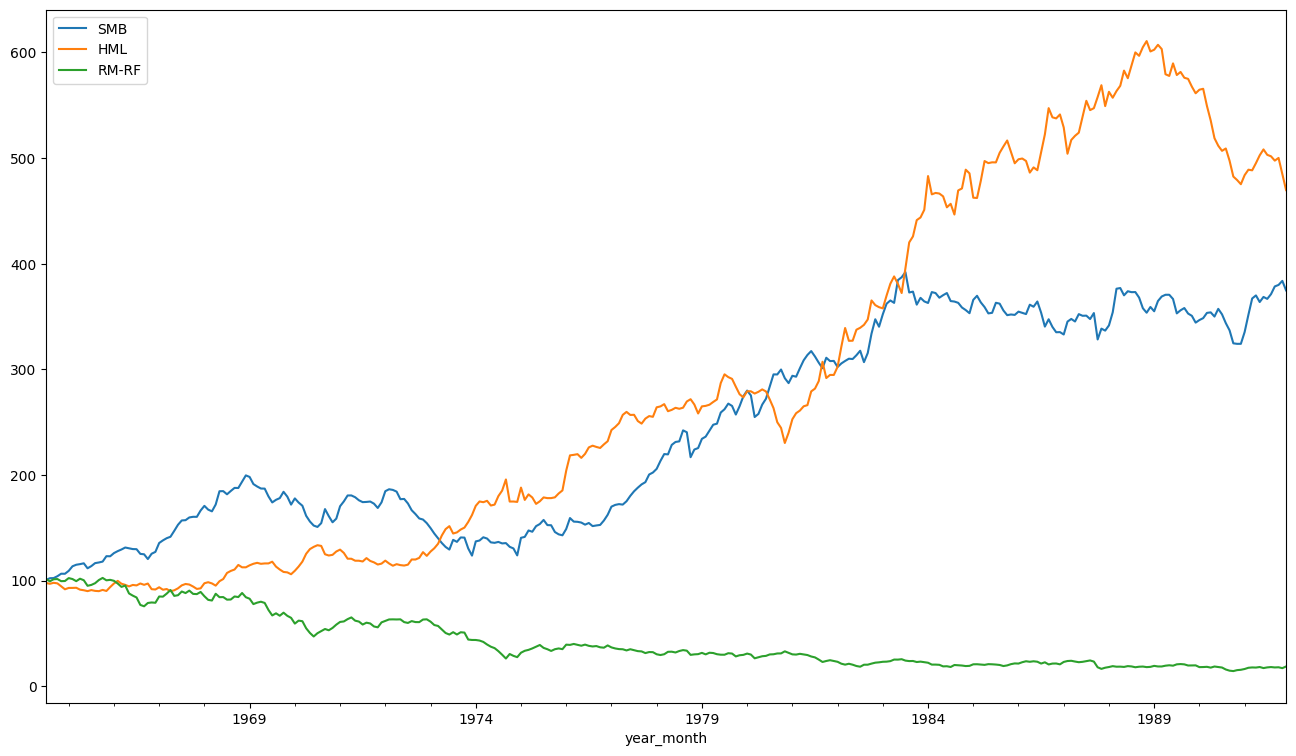

In [1293]:
((1 + factors_df).cumprod()*100).plot()

In [1294]:
sort_df_.drop(columns=['year','month','exchange_code_x'],inplace=True)
sort_df_.rename(columns={'exchange_code_y':'exchange_code'},inplace=True)

### 3个因子的相关性分析

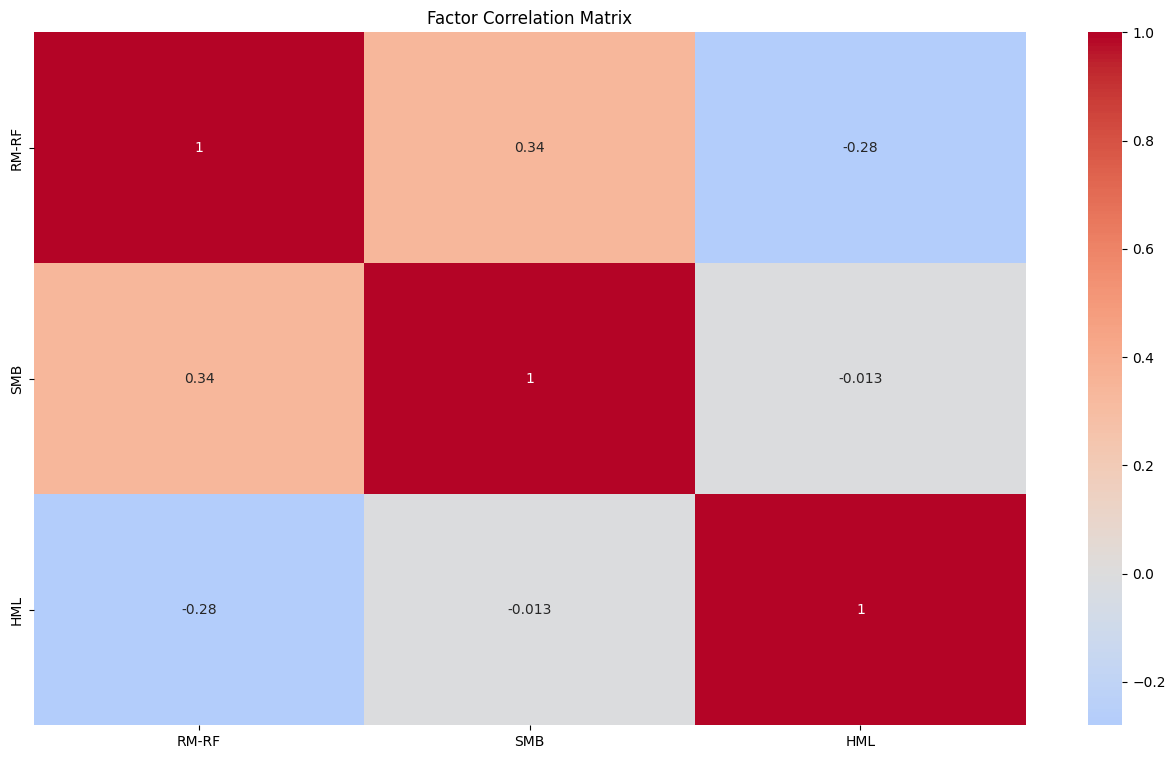

In [1295]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(
    factors_df[['RM-RF','SMB','HML']].corr(),
    annot=True,
    cmap='coolwarm',
    center=0
)
plt.title('Factor Correlation Matrix')
plt.show()

 1. 因子独立性
SMB 和 HML 几乎不相关（-0.013）→ 说明它们代表不同风险维度，可同时使用。

3. 市场因子主导性
RM-RF 与 SMB 正相关（0.34）、与 HML 负相关（-0.28）
市场涨跌会带动规模/价值风格切换。<br>
牛市时，投资者风险偏好上升 → 更愿意买波动大、弹性高的小盘股 & 成长股 → 导致 SMB 正收益、HML 负收益；熊市则相反。

5. 没有多重共线性风险
所有因子间相关系数绝对值 < 0.4 

6. 符合经典理论
结果与 Fama-French 1993 美股结论一致 



#  因变量（公式左侧预期超额回报）计算

构造25个投资组合，构造方法和因子构建中的方法一致，唯一的差别是做5x5独立双重排序。<br>
计算25个组合的月度加权收益率，计算超额收益 <br>
以25个组合的超额收益为因变量，以三因子为自变量，进行时间序列回归，股票定价误差和$\beta$ <br>
对定价误差进行$\alpha$检验，如果定价误差不显著不等于0，则多因子模型有效 <br>
对$\beta$进行检验，发现$\beta$显著不等于0，说明因子对25个投资组合的超额收益率有显著的解释能力。<br>

todo: 理解因变量的计算过程

### todo: 理解因变量的计算过程

In [1296]:
sort_df_.columns

Index(['stock_code', 'year_month', 'ret', 'rf', 'ex_ret', 'bm_date', 'bm',
       'mkt_date', 'exchange_code', 'mktcap'],
      dtype='object')

In [1297]:
q = dict()
keys = ['q'+str(i) for i in range(1, 5)]
values = [0.2,0.4,0.6,0.8]
q.update(zip(keys,values))

In [1298]:
list(zip(keys,values))[3]

('q4', 0.8)

In [1299]:
q.items()

dict_items([('q1', 0.2), ('q2', 0.4), ('q3', 0.6), ('q4', 0.8)])

In [1300]:
quantile_df = pd.DataFrame()
for key, value in q.items():
    quantile_df[key] = sort_df_.groupby(['bm_date'])['bm'].quantile(value)

In [1301]:
sort_df_ = pd.merge(sort_df_, quantile_df, on='bm_date')

In [1302]:
sort_df_.columns

Index(['stock_code', 'year_month', 'ret', 'rf', 'ex_ret', 'bm_date', 'bm',
       'mkt_date', 'exchange_code', 'mktcap', 'q1', 'q2', 'q3', 'q4'],
      dtype='object')

In [1303]:
q = dict()
keys = ['Q'+str(i) for i in range(1, 5)]
values = [0.2,0.4,0.6,0.8]
q.update(zip(keys,values))
quantile_df = pd.DataFrame()
for key, value in q.items():
    quantile_df[key] = sort_df_.groupby(['mkt_date'])['mktcap'].quantile(value)
sort_df_ = pd.merge(sort_df_, quantile_df, on='mkt_date')

In [1304]:
sort_df_.head()

,stock_code,year_month,ret,rf,ex_ret,bm_date,bm,mkt_date,exchange_code,mktcap,q1,q2,q3,q4,Q1,Q2,Q3,Q4
0,10001,1987-07,0.021277,0.004667,0.016609,1986,0.787814,1987-06,3.0,5822125.0,0.291689,0.49936,0.703307,0.997286,11982750.0,33681375.0,95617250.0,386456000.0
1,10001,1987-08,0.083333,0.004717,0.078616,1986,0.787814,1987-06,3.0,5822125.0,0.291689,0.49936,0.703307,0.997286,11982750.0,33681375.0,95617250.0,386456000.0
2,10001,1987-09,-0.038462,0.005417,-0.043878,1986,0.787814,1987-06,3.0,5822125.0,0.291689,0.49936,0.703307,0.997286,11982750.0,33681375.0,95617250.0,386456000.0
3,10001,1987-10,0.020000,0.003353,0.016648,1986,0.787814,1987-06,3.0,5822125.0,0.291689,0.49936,0.703307,0.997286,11982750.0,33681375.0,95617250.0,386456000.0
4,10001,1987-11,-0.029412,0.002927,-0.032339,1986,0.787814,1987-06,3.0,5822125.0,0.291689,0.49936,0.703307,0.997286,11982750.0,33681375.0,95617250.0,386456000.0


In [1305]:
portfolios_bm = dict()
keep_cols = ['stock_code', 'year_month', 'ret', 'rf', 'ex_ret', 'bm_date', 'bm',
       'mkt_date', 'exchange_code', 'mktcap' ]

portfolios_bm['bm1'] = sort_df_.loc[sort_df_['bm'] <= sort_df_['q1'],keep_cols].copy()
for i in range(2,5):
    idx = (sort_df_[f'q{i-1}'] <= sort_df_['bm']) & (sort_df_['bm'] <= sort_df_[f'q{i}'])
    portfolios_bm[f'bm{i}'] = sort_df_.loc[idx,keep_cols].copy()
portfolios_bm['bm5'] = sort_df_.loc[sort_df_['bm'] >= sort_df_['q4'],keep_cols].copy()

In [1306]:
portfolios_mkt = dict()
keep_cols = ['stock_code', 'year_month', 'ret', 'rf', 'ex_ret', 'bm_date', 'bm',
       'mkt_date', 'exchange_code', 'mktcap' ]

portfolios_mkt['mkt1'] = sort_df_.loc[sort_df_['mktcap'] <= sort_df_['Q1'],keep_cols].copy()
for i in range(2,5):
    idx = (sort_df_[f'Q{i-1}'] <= sort_df_['mktcap']) & (sort_df_['mktcap'] <= sort_df_[f'Q{i}'])
    portfolios_mkt[f'mkt{i}'] = sort_df_.loc[idx,keep_cols].copy()
portfolios_mkt['mkt5'] = sort_df_.loc[sort_df_['mktcap'] >= sort_df_['Q4'],keep_cols].copy()

In [1307]:
portfolios_bm.keys()

dict_keys(['bm1', 'bm2', 'bm3', 'bm4', 'bm5'])

In [1308]:
portfolios_dpt = dict()
for bm in portfolios_bm.keys():
    for mkt in portfolios_mkt.keys():
        portfolios_dpt[f'{bm}_{mkt}'] = pd.merge(portfolios_bm[bm][['stock_code','year_month']],
                                            portfolios_mkt[mkt],
                                             on=['stock_code','year_month'])

In [1309]:
portfolios_dpt.keys()

dict_keys(['bm1_mkt1', 'bm1_mkt2', 'bm1_mkt3', 'bm1_mkt4', 'bm1_mkt5', 'bm2_mkt1', 'bm2_mkt2', 'bm2_mkt3', 'bm2_mkt4', 'bm2_mkt5', 'bm3_mkt1', 'bm3_mkt2', 'bm3_mkt3', 'bm3_mkt4', 'bm3_mkt5', 'bm4_mkt1', 'bm4_mkt2', 'bm4_mkt3', 'bm4_mkt4', 'bm4_mkt5', 'bm5_mkt1', 'bm5_mkt2', 'bm5_mkt3', 'bm5_mkt4', 'bm5_mkt5'])

In [1312]:
portfolios_ret_mean = dict()
for k in portfolios_dpt.keys():
    portfolios_dpt[k]['weight'] = portfolios_dpt[k].groupby('year_month')['mktcap'].transform('sum')
    portfolios_dpt[k]['vw_ret'] = portfolios_dpt[k]['ret'] * portfolios_dpt[k]['weight']
    portfolios_ret_mean[k] = portfolios_dpt[k].groupby(['year_month'])['vw_ret'].sum()


In [1313]:
for k in portfolios_ret_mean.keys():
    portfolios_ret_mean[k] = pd.DataFrame(portfolios_ret_mean[k])
    portfolios_ret_mean[k].columns = ['vw_ret']
    portfolios_ret_mean[k] = pd.merge(portfolios_ret_mean[k],rf,on=['year_month'])
    portfolios_ret_mean[k]['vw_ex_ret'] = portfolios_ret_mean[k][
        'vw_ret'] - portfolios_ret_mean[k]['rf']
    

In [1314]:
portfolios_ret_mean.keys()

dict_keys(['bm1_mkt1', 'bm1_mkt2', 'bm1_mkt3', 'bm1_mkt4', 'bm1_mkt5', 'bm2_mkt1', 'bm2_mkt2', 'bm2_mkt3', 'bm2_mkt4', 'bm2_mkt5', 'bm3_mkt1', 'bm3_mkt2', 'bm3_mkt3', 'bm3_mkt4', 'bm3_mkt5', 'bm4_mkt1', 'bm4_mkt2', 'bm4_mkt3', 'bm4_mkt4', 'bm4_mkt5', 'bm5_mkt1', 'bm5_mkt2', 'bm5_mkt3', 'bm5_mkt4', 'bm5_mkt5'])

In [1315]:
portfolios_ret_mean['bm1_mkt1'].head()

,year_month,vw_ret,rf,vw_ex_ret
0,1964-07,8.332754e+06,0.002716,8.332754e+06
1,1964-08,4.521976e+07,0.002720,4.521976e+07
2,1964-09,6.209684e+07,0.002936,6.209684e+07
3,1964-10,7.755734e+07,0.002856,7.755734e+07
4,1964-11,-1.127932e+07,0.002978,-1.127932e+07


In [1316]:
for key in portfolios_ret_mean.keys():
    portfolios_ret_mean[key].set_index(['year_month'],inplace=True)

In [1317]:
portfolios_ret_mean['bm1_mkt1'].head()

,vw_ret,rf,vw_ex_ret
year_month,,,
1964-07,8.332754e+06,0.002716,8.332754e+06
1964-08,4.521976e+07,0.002720,4.521976e+07
1964-09,6.209684e+07,0.002936,6.209684e+07
1964-10,7.755734e+07,0.002856,7.755734e+07
1964-11,-1.127932e+07,0.002978,-1.127932e+07


In [1318]:
dependance = pd.DataFrame(np.hstack([pf[['vw_ex_ret']] for pf in portfolios_ret_mean.values()]))
dependance.index = portfolios_ret_mean['bm1_mkt1'].index
dependance.columns = portfolios_ret_mean.keys()

In [1319]:
dependance.to_csv('dependance.csv')

In [1323]:
pd.merge(dependance, factors_df, on=['year_month']).to_csv('data.csv', index=False)


In [1324]:
for k in portfolios_ret_mean.keys():
    portfolios_ret_mean[k].drop(columns =['vw_ret','rf'],inplace=True)

In [1325]:
factors_df.head()

,SMB,HML,RM-RF
year_month,,,
1964-07,0.005448,-0.022953,0.013765
1964-08,0.016718,-0.007786,-0.020713
1964-09,0.001075,0.009564,0.019680
1964-10,0.017278,-0.005399,0.001944
1964-11,0.022828,-0.028159,-0.019761


# 模型回归

In [1334]:
import statsmodels.api as sm

# 假设 df 已经是你的合并数据
# 因变量
y = df['vw_ex_ret']

# 自变量
X = df[['RM_RF','SMB','HML']]

# 加上截距项
X = sm.add_constant(X)

# OLS 回归
model = sm.OLS(y, X).fit()

# 查看结果
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              vw_ex_ret   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     141.3
Date:                Sat, 03 Jan 2026   Prob (F-statistic):           1.20e-58
Time:                        17:04:44   Log-Likelihood:                -8189.5
No. Observations:                 330   AIC:                         1.639e+04
Df Residuals:                     326   BIC:                         1.640e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.524e+09   8.32e+08      5.437      0.0

### 回归分析


1. 模型概览

本次分析使用 Fama-French 三因子模型回归组合市值加权超额收益 (`vw_ex_ret`)：

- 因变量：`vw_ex_ret`（组合超额收益）  
- 自变量：市场超额收益 `RM_RF`、规模因子 `SMB`、价值因子 `HML`  
- 样本期：330 个观测值

模型拟合情况：

| 指标 | 数值 |
|------|------|
| R-squared | 0.565 |
| Adjusted R-squared | 0.561 |
| F-statistic | 141.3 (p ≈ 0) |
| Durbin-Watson | 1.628 |

> 说明：模型解释了约 56% 的组合收益波动，整体显著，但残差存在轻微自相关。

---

2. 回归系数及组合风格

| 因子 | 系数 (coef) | 标准误 (std err) | t 值 | P>|t| | 95% 置信区间 | 风格解读 |
|------|-------------|----------------|------|------|----------------|----------|
| const | 4.524e+09 | 8.32e+08 | 5.437 | 0.000 | [2.89e+09, 6.16e+09] | 基础超额收益，当因子为零时仍有正收益 |
| RM_RF | 2.436e+11 | 1.93e+10 | 12.616 | 0.000 | [2.06e+11, 2.82e+11] | 市场敏感度高，组合随市场波动明显 |
| SMB   | 3.32e+11  | 3.12e+10 | 10.627 | 0.000 | [2.71e+11, 3.93e+11] | 正且显著 → 投资组合偏向小盘股风格 |
| HML   | 1.803e+11 | 3.22e+10 | 5.591  | 0.000 | [1.17e+11, 2.44e+11] | 正且显著 → 投资组合偏向价值股风格 |

> 说明：所有系数显著且为正，组合为“小盘价值股”风格，同时高度暴露于市场因子。

---

3. 市值/小盘股特性分析

- **小盘股特性**：
  - 市值小，波动大，流动性相对低。  
  - 长期超额收益倾向高于大盘股。  

- **SMB 系数解读**：
  - 系数 = 3.32e+11，显著为正 → 小盘股对组合收益贡献明显。  
  - 说明组合持仓中小盘股票比例高，风险溢价来源主要之一为小盘股效应。

- **HML 系数解读**：
  - 系数 = 1.803e+11，显著为正 → 高账面价值比股票贡献正收益。  
  - 说明组合偏向价值股，存在价值溢价。

---

4. 综合结论

1. 投资组合属于 **小盘价值股风格**，对市场波动敏感。  
2. 市值因子（SMB）贡献大，说明组合超额收益部分来源于小盘股溢价。  
3. 价值因子（HML）贡献次之，说明组合同时受价值股溢价驱动。  
4. 残差偏态略高、峰度大 → 极端收益存在，需要关注尾部风险。  
5. 建议可通过图示展示因子贡献，或扩展到四因子模型加入动量因子，进一步分析组合收益来源。
